In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import csv
from bs4 import BeautifulSoup

def setup_driver():
    """Sets up the WebDriver for Chrome."""
    options = webdriver.ChromeOptions()
    options.add_argument('--no-sandbox')  # Bypass OS security model
    options.add_argument('--disable-dev-shm-usage')  # Overcome limited resource problems
    driver = webdriver.Chrome(options=options)
    return driver

def print_department_text(html_content):
    """Extracts and returns the text after the <h2 class="card__title"> tag."""
    soup = BeautifulSoup(html_content, 'html.parser')
    card_titles = soup.find_all('h2', class_='card__title')
    departments = [title.text.strip() for title in card_titles]
    return departments

def print_why_study_with_us_section(driver, course_link):
    """Returns the HTML content of the 'why study with us' section."""
    driver.get(course_link)
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'body')))
    try:
        why_study_with_us_section = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.ID, 'why-study-with-us'))
        )
        html_content = why_study_with_us_section.get_attribute('outerHTML')
        return print_department_text(html_content)
    except TimeoutException:
        print("Failed to locate or extract the 'why study with us' section.")
        return []

# Setup WebDriver
driver = setup_driver()
initial_url = "https://www.lse.ac.uk/programmes/search-courses?studyType=0%2F1%2F26%2F85%2F86"
driver.get(initial_url)

def process_course_page(course_link):
    """ Visits each course link and extracts the course name, median salary, and department. """
    departments = print_why_study_with_us_section(driver, course_link)
    department = ', '.join(departments) if departments else "Department not found."
    
    try:
        course_name = driver.find_element(By.CSS_SELECTOR, 'h1.hero__title span').text.strip()
    except NoSuchElementException:
        course_name = "Course name not found."
    try:
        salary_div = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, 'section#graduate-destinations div.salary')))
        median_salary = salary_div.text.strip()
    except TimeoutException:
        median_salary = "Salary not found."

    return course_name, median_salary, department

def navigate_to_next_page():
    """Navigates to the next page if possible."""
    try:
        next_page_button = WebDriverWait(driver, 20).until(
            EC.element_to_be_clickable((By.XPATH, "//li[contains(@class, 'next')]//button[contains(., 'Next')]")))
        next_page_button.click()
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'body')))
        return driver.current_url
    except TimeoutException:
        return None

courses_info = []
current_page_url = initial_url

while True:
    WebDriverWait(driver, 20).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'h2.card__title a')))
    courses = [(elem.get_attribute('href'), elem.text) for elem in driver.find_elements(By.CSS_SELECTOR, 'h2.card__title a')]
    for course_link, _ in courses:
        course_name, median_salary, department = process_course_page(course_link)
        courses_info.append((course_name, median_salary, department))
        driver.get(current_page_url)
    new_page_url = navigate_to_next_page()
    if new_page_url:
        current_page_url = new_page_url
    else:
        break

driver.quit()

# Save results to a CSV file
csv_file_path = 'Data/output.csv'
with open(csv_file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Course Name', 'Median Salary', 'Department'])
    writer.writerows(courses_info)

print("Data extraction complete. Results saved to CSV.")


Data extraction complete. Results saved to CSV.


Postgraduate Courses:

In [23]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import csv
from bs4 import BeautifulSoup
import os

def setup_driver():
    """Sets up the WebDriver for Chrome."""
    options = webdriver.ChromeOptions()
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')
    driver = webdriver.Chrome(options=options)
    return driver

def process_course_page(driver, course_link):
    """Visits each course link and extracts the course name, median salary, and department for postgraduate courses."""
    driver.get(course_link)
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'body')))
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Extracting course name
    course_name_elem = soup.find('h1', class_='pageTitle')
    course_name = course_name_elem.text.strip() if course_name_elem else "Course name not found."

    # Finding department
    department_elem = soup.find('li', class_='keyDetails__item--dept')
    department = department_elem.text.strip() if department_elem else "Department not found."

    # Extracting median salary directly from the Careers accordion content
    # Extracting median salary directly from the Careers accordion content
    median_salary = "Salary not found."
    careers_accordion = soup.find('h1', class_='accordion__title', string=lambda text: 'Careers' in text if text else False)
    if careers_accordion:
        careers_content = careers_accordion.find_next('div', class_='accordion__content')
        if careers_content:
            salary_tag = careers_content.find('strong', string=lambda text: "Median salary" in text if text else False)
            if salary_tag:
                median_salary = salary_tag.next_sibling.strip() if salary_tag.next_sibling else "Salary not found."

    print(median_salary)
    return course_name, median_salary, department


# Main scraping function
def scrape_courses(base_url):
    driver = setup_driver()
    driver.get(base_url)
    courses_info = []
    current_page_url = base_url  # Initialize current page URL

    while True:
        # Wait for the course links to be visible and then collect them
        WebDriverWait(driver, 20).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'h2.card__title a')))
        course_elements = driver.find_elements(By.CSS_SELECTOR, 'h2.card__title a')
        courses = [(elem.get_attribute('href'), elem.text) for elem in course_elements]

        for course_link, _ in courses:
            driver.get(course_link)
            WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'body')))
            course_info = process_course_page(driver, course_link)
            courses_info.append(course_info)
            driver.get(current_page_url)  # Go back to the current list page, not the base URL
            WebDriverWait(driver, 20).until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, 'h2.card__title a')))  # Wait until all course links are visible again

        new_page_url = navigate_to_next_page(driver)
        if new_page_url:
            current_page_url = new_page_url  # Update the current page URL
            driver.get(new_page_url)  # Navigate to the next page
            WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.TAG_NAME, 'body')))  # Ensure the page is loaded
        else:
            break  # Exit the loop if there are no more pages

    driver.quit()
    return courses_info

def navigate_to_next_page(driver):
    """Navigates to the next page if possible."""
    try:
        next_page_button = WebDriverWait(driver, 20).until(
            EC.element_to_be_clickable((By.XPATH, "//li[contains(@class, 'next')]//button[contains(., 'Next')]")))
        next_page_button.click()
        WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'body')))
        return driver.current_url
    except TimeoutException:
        return None

    


def save_to_csv(data, filename):
    """Appends the data to a CSV file or creates it if it doesn't exist."""
    file_exists = os.path.isfile(filename)  # Check if the file already exists

    with open(filename, 'a', newline='') as file:  # Open the file in append mode
        writer = csv.writer(file)
        
        if not file_exists:
            writer.writerow(['Course Name', 'Median Salary', 'Department'])  # Write header only if the file does not exist
        
        writer.writerows(data)


# URL for postgraduate courses
postgraduate_url = "https://www.lse.ac.uk/programmes/search-courses?studyType=0%2F1%2F26%2F85%2F87"
postgraduate_courses = scrape_courses(postgraduate_url)
save_to_csv(postgraduate_courses, 'Data/output.csv')
print("Data extraction complete. Results added to 'output.csv'.")



£33,000
£42,000
Salary not found.


KeyboardInterrupt: 

Now the output from the webscraping will be cleaned:

In [44]:
import pandas as pd

# Load the original CSV file
data_path = 'Data/output.csv'
data = pd.read_csv(data_path, encoding='ISO-8859-1')

# Simplify department names by removing "Department of "
data['Department'] = data['Department'].str.replace('Department of ', '')

# Replace "Salary not found" with NaN
data['Median Salary'] = data['Median Salary'].replace('Salary not found', pd.NA)

# Convert salary values to numeric, removing non-numeric characters like £ and commas
data['Median Salary'] = pd.to_numeric(data['Median Salary'].str.replace('[£,]', '', regex=True), errors='coerce')

# Determine median salary to categorize into 'High' and 'Low' groups
median_salary = data['Median Salary'].median()
data['Salary Group'] = data['Median Salary'].apply(lambda x: 'High' if x >= median_salary else 'Low')

# Remove duplicate rows
data.drop_duplicates(inplace=True)

# Save the cleaned data to a new CSV file
clean_data_path = 'cleaned_output.csv'
data.to_csv(clean_data_path, index=False)

print(f"Data has been cleaned, duplicates removed, and saved to {clean_data_path}.")


Data has been cleaned, duplicates removed, and saved to cleaned_output.csv.


Using the cleaned output, we can begin visualizing the data to explore some of its insights:

Notably, departments were split into two groups based on the median salary (post-graduation). The threshold between high and low income departments was the actual median of the median salary values.Through this grouping, the analysis of the effect of brexit can be split between the two salary groups. 

To reiterate, the 2021 cohort was the first year group of EU students which now faced international fees, i.e., they are the first cohort to face significantly higher costs.

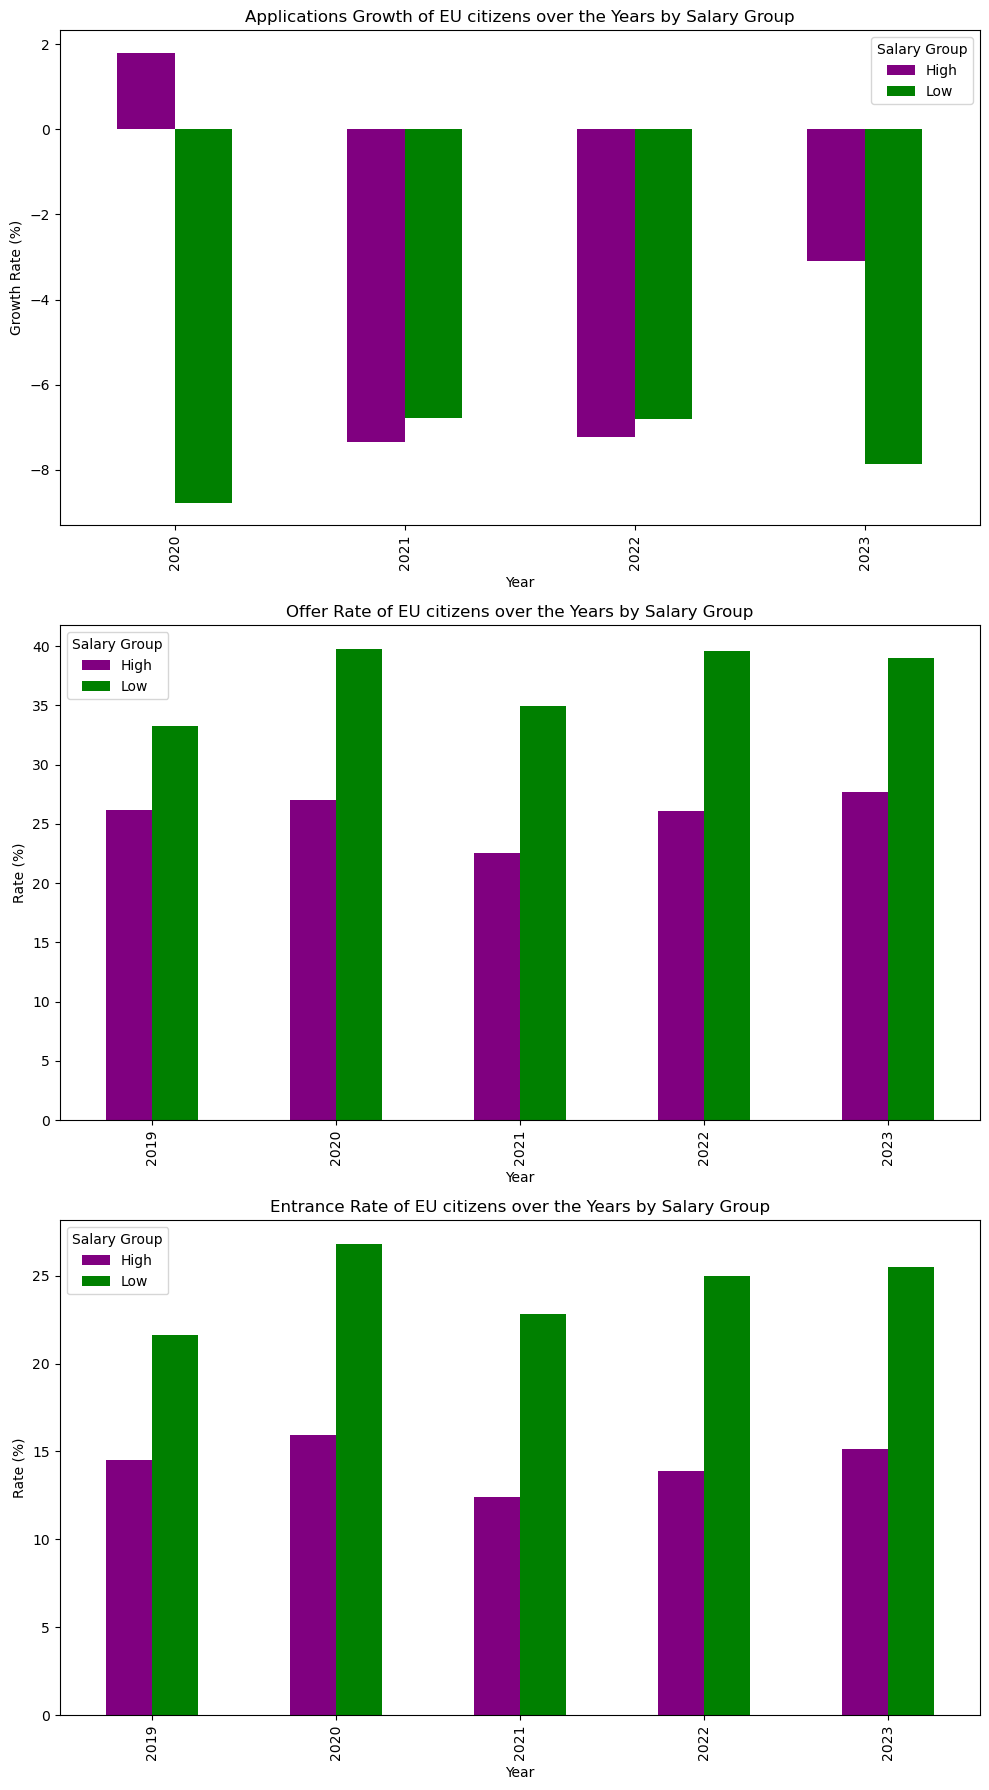

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('Data/PhilipEUCleaned.csv')

# Define the years to aggregate data over
years = ['2019', '2020', '2021', '2022', '2023']

# Prepare the aggregation for applications, offers, and entrances by year and salary group
agg_columns = []
for year in years:
    agg_columns.append((f'Applications {year}', pd.NamedAgg(column=f'Applications {year}', aggfunc='sum')))
    agg_columns.append((f'Offers {year}', pd.NamedAgg(column=f'Offers {year}', aggfunc='sum')))
    agg_columns.append((f'Entrances {year}', pd.NamedAgg(column=f'Entrances {year}', aggfunc='sum')))

agg_data = data.groupby('Salary Group').agg(**dict(agg_columns)).reset_index()

# Calculate offer and entrance rates as a percentage of applications
for year in years:
    agg_data[f'Offer Rate {year}'] = agg_data[f'Offers {year}'] / agg_data[f'Applications {year}'] * 100
    agg_data[f'Entrance Rate {year}'] = agg_data[f'Entrances {year}'] / agg_data[f'Applications {year}'] * 100

# Calculate growth rate of applications year-over-year for each salary group
for year in years[1:]:  # Start from 2020 to be able to calculate growth from 2019
    previous_year = str(int(year) - 1)
    agg_data[f'Applications Growth {year}'] = (
        (agg_data[f'Applications {year}'] - agg_data[f'Applications {previous_year}']) / agg_data[f'Applications {previous_year}']) * 100

# Prepare data for plotting growth rates
growth_columns = [f'Applications Growth {year}' for year in years[1:]]  # Exclude 2019 as there's no previous year data
melted_growth_data = agg_data.melt(id_vars=['Salary Group'], value_vars=growth_columns, var_name='Year_Type', value_name='Growth Rate')
melted_growth_data['Year'] = melted_growth_data['Year_Type'].str.extract('(\d+)').astype(int)
melted_growth_data['Type'] = 'Applications Growth'

# Reshape the rate data for plotting
rate_columns = [col for col in agg_data.columns if 'Rate' in col and 'Growth' not in col]
melted_rate_data = agg_data.melt(id_vars=['Salary Group'], value_vars=rate_columns, var_name='Year_Type', value_name='Rate')
melted_rate_data['Year'] = melted_rate_data['Year_Type'].str.extract('(\d+)').astype(int)
melted_rate_data['Type'] = melted_rate_data['Year_Type'].apply(lambda x: 'Offer Rate' if 'Offer Rate' in x else ('Entrance Rate' if 'Entrance Rate' in x else 'Applications'))

# Combine growth data with other rate data for plotting
combined_data = pd.concat([melted_growth_data, melted_rate_data])

# Plotting with applications growth rate
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 18))

# Plot settings
types = ['Applications Growth', 'Offer Rate', 'Entrance Rate']
colors = ['purple', 'green', 'red']
for ax, rate_type in zip(axes.flatten(), types):
    pivot_df = combined_data[combined_data['Type'] == rate_type].pivot(index='Year', columns='Salary Group', values='Growth Rate' if 'Growth' in rate_type else 'Rate')
    pivot_df.plot(kind='bar', ax=ax, color=colors)
    ax.set_title(f'{rate_type} of EU citizens over the Years by Salary Group')
    ax.set_ylabel('Growth Rate (%)' if 'Growth' in rate_type else 'Rate (%)')
    ax.set_xlabel('Year')

plt.tight_layout()
plt.show()

## Analysis of Offer and Entrance rate

From the first two graphs it is visible that both offer and etrance rates were rising in 2019 and 2020, then declined in 2021 but from then gradually started to recover since. This suggests LSE was more than usually competetive for the 2021 cohort which may be a result of the school reopening following covid in 2020 and presumably there was still much uncertainty regarding how teaching, exams, etc. were to be carried out that year. For example students who entered in 2021 still had winter exams online and some of the lectures were held purely online. This uncertainty may have caused LSE to admit a lower number of students than usually which may explain the lower offer rate.

This can be in fact verified as the number a lower acceptance rate, holding fixed how many students were admitted, would mean that more students have applied. However, as the number of applications declined for this year it does mean that LSE simply admitted less students this year.   

Therefore as Covid had such a significant impact on the university it is hard to interpret the effect of Brexit via raised tuition fees for students from these graphs. Especially as the patterns displayed by both department groups is very similar so comparing the two departments does not reveal significant insights. Importantly, the effect of Brexit on the acceptance rate does not seem to be different between the two groups of departments.

Thus now the annual growth in applications will be plotted to focus on the effect of increased tuition fees from 2021 onwards for EU students.

## Analysis of annual growth in applications

From the third graph it is visible that application growth rate from EU students for the high income departments was positive in the year before Brexit (2020), but from 2021 it is negative.  This makes sense as due to Brexit, EU students now pay significantly higher tuition fees, so they are less inclined to apply and this may explain why the application growth rate is negative from 2021 onwards. 

In comparison, the application growth rate for EU students for "low income" departments has been negative every year in the dataset and therefore may  have not been affected by the Brexit outcome. Especially as the growth rate in applications was already negative in the preceding year, which indicates that other factors may have been involved which also explain why for the low income departments the growth rate in applications has been negative every year. 

This alligns with what was briefly discussed in the introduction. EU Students which applied to departments with low incomes originally presumably have less financially motivated decisions, i.e., the financial aspect is less significant to them. Therefore, the effect of Brexit raising their tuition fees is less important for them which may explain why their growth rate in applications seem to be unaffected by the result. In fact their Year-on-Year growth rate is  actually higher in 2021 than 2020 which further underlines this point and again suggests that for these applicants there was perhaps a alternative factor which the data does not capture (although it is still negative).

Furthermore, the positive growth rate in 2020 for high-income departments could be attributed to students rushing to apply before the anticipated tuition hikes in 2021. This urgency seems less relevant for applicants to low-income departments, where the growth rate was already negative at that time.

Moreover, the consistent negative growth rate in low-income departments may also relate to Brexit, as the increased tuition fees might not be seen as a worthwhile investment, especially given the relatively lower financial return. This might explain why there was no surge in applications in 2020 for these departments, unlike their high-income counterparts.



# Das FOLGENDE HIER FÜR DIE CONCLUSION

Unfortunately data was only available from 2019 onwards. As Brexit was announced 2016 already the data does not reveal anything on the immediate effect of the announcement. For example, the Brexit referendum held then likely immediately evoked much economic uncertainty. This would be especially of interest to those students who value the financial aspect significantly, because this may have also dissusaded them from applying to LSE and UK in general as they are now perhaps worried if studying there is the best decision in terms of future financial security. Especially considering the fact that people who study in the UK typcially start working here. 

Therefore our data only focusses on the real effect of tuition fees being raised for EU students which is arguably the most significant implication of Brexit for these EU students. However, the notion around economic uncertainty is an inmportant factor, especially when arguing that the significance of financial aspects for the EU students applying for high income departments so this is one major limitation of the dataset that was available. Therefore, a natural extension of this analysis is to increase the sample period and especially to the years before and after the brexit referendum.

Now to dive deeper into the effect of Brexit on the number of applicants across departments with different starting salaries, can run a regression of the difference in applications on median salary for the various departments (where salary data was available). 

Specifically the difference in applicants between years 2023 and 2019 was taken (i.e. number of applications for a department in 2023 minus number of applications for a department in 2019). This ensures that the covid years 2020 and 2021 were not included but also using 2023 as the post brexit value means there has been some time for the number of applications to stabilize following the year 2021 increased .


In [15]:
import pandas as pd
import plotly.express as px
from sklearn.linear_model import LinearRegression

# Load the CSV files
file_eu_cleaned = pd.read_csv('Data/PhilipEUCleaned.csv')
file_output = pd.read_csv('Data/cleaned_output.csv')

# Filter for only undergraduate courses in the EU cleaned data
undergrad_eu_cleaned = file_eu_cleaned[file_eu_cleaned['Program'].str.contains("UG Degree")]

# Compute total applications for the years 2020 (pre-Brexit) and 2022 (post-Brexit)
pre_brexit_apps = undergrad_eu_cleaned.groupby('Department')['Applications 2019'].sum()
post_brexit_apps = undergrad_eu_cleaned.groupby('Department')['Applications 2023'].sum()

# Calculate the difference in applications
application_difference = post_brexit_apps - pre_brexit_apps

# Get the median salary for each department from the second file, ensuring to match only undergraduate departments
median_salaries = file_output[file_output['Course Name'].str.contains("BSc")].groupby('Department')['Median Salary'].median()

# Join the application difference and median salary dataframes
department_data = pd.DataFrame({
    'Median Salary': median_salaries,
    'Application Difference': application_difference,
    'Total Pre-Brexit Applications': pre_brexit_apps,
    'Total Post-Brexit Applications': post_brexit_apps
}).dropna()

# Add department names for plotting
department_data['Department'] = department_data.index

# Perform linear regression
X = department_data['Median Salary'].values.reshape(-1, 1)
y = department_data['Application Difference'].values
model = LinearRegression()
model.fit(X, y)

# Predictions for the line
department_data['Predicted Difference'] = model.predict(X)

# Create the interactive plot
fig = px.scatter(department_data, x='Median Salary', y='Application Difference', trendline='ols',
                 labels={
                     'Median Salary': 'Median Salary (£)',
                     'Application Difference': 'Difference in Total Applications (2023 vs 2019)'
                 },
                 hover_data=['Department', 'Total Pre-Brexit Applications', 'Total Post-Brexit Applications'],
                 title='Interactive Plot: Median Salary vs. Application Difference Post vs Pre Brexit for Undergraduate Courses')
fig.update_traces(marker=dict(size=8),
                  selector=dict(mode='markers'))
fig.show()

## Interpretation of the OLS
In this analysis, we delve into the relationship between two key variables: the difference in total applications from EU students across academic departments from 2019 to 2023, and the median salary earned by graduates of those departments after completing their studies. Each data point on our graph represents a distinct academic department, with the change in EU student applications plotted on the y-axis and the median salary of graduates on the x-axis.

Our primary question centers on whether the expected wage advertised by academic departments influences the decision-making process of prospective applicants, particularly in light of the Brexit referendum and subsequent tuition fee adjustments for EU students. From a financial perspective, we conceptualize further education as an investment, with the net present value of this investment comprising the upfront costs (i.e., tuition fees) and the anticipated future returns in the form of expected salaries.

Higher tuition fees may prompt decision-makers to seek more financially lucrative educational pathways, opting for degrees associated with higher projected earnings. This rationale gains further credence when considering students' long-term income prospects. Some EU students may even resort to student loans, the repayment burden of which naturally increases with raised tuition fees. However, a higher expected salary can potentially alleviate the financial strain associated with loan repayment.

Upon conducting Ordinary Least Squares (OLS) regression analysis on our dataset, we observe a positive correlation between median salary and the difference in applications. Specifically, departments boasting a £10,000 higher median salary, on average, witnessed a corresponding increase of approximately 21 applicants in the difference between 2019 and 2023. This finding lends empirical support to our hypothesis, suggesting that the Brexit referendum may have prompted EU citizens to gravitate toward academic departments with a track record of producing graduates with higher earning potential.

Thus, it seems reasonable to infer that the Brexit referendum spurred EU citizens to recalibrate their application preferences, favoring departments with a demonstrated propensity for fostering graduates with elevated salary prospects.

Summary table:

In [41]:
import pandas as pd
import statsmodels.api as sm

# Load the CSV files
file_eu_cleaned = pd.read_csv('Data/PhilipEUCleaned.csv')
file_output = pd.read_csv('Data/cleaned_output.csv')

# Filter for only undergraduate courses in the EU cleaned data
undergrad_eu_cleaned = file_eu_cleaned[file_eu_cleaned['Program'].str.contains("UG Degree")]

# Compute total applications for the years 2020 (pre-Brexit) and 2022 (post-Brexit)
pre_brexit_apps = undergrad_eu_cleaned.groupby('Department')['Applications 2019'].sum()
post_brexit_apps = undergrad_eu_cleaned.groupby('Department')['Applications 2023'].sum()

# Calculate the difference in applications
application_difference = post_brexit_apps - pre_brexit_apps

# Get the median salary for each department from the second file, ensuring to match only undergraduate departments
median_salaries = file_output[file_output['Course Name'].str.contains("BSc")].groupby('Department')['Median Salary'].median()

# Join the application difference and median salary dataframes
department_data = pd.DataFrame({
    'Median Salary': median_salaries,
    'Application Difference': application_difference,
    'Total Pre-Brexit Applications': pre_brexit_apps,
    'Total Post-Brexit Applications': post_brexit_apps
}).dropna()

# Add department names for indexing
department_data['Department'] = department_data.index

# Set up the X and y matrices for the regression, with an intercept added to X
X = department_data[['Median Salary']]
X = sm.add_constant(X)  # Adds a constant term to the predictor
y = department_data['Application Difference']

# Fit the model
model = sm.OLS(y, X)
results = model.fit()

# Print the summary of the regression
print(results.summary())


                              OLS Regression Results                              
Dep. Variable:     Application Difference   R-squared:                       0.035
Model:                                OLS   Adj. R-squared:                 -0.061
Method:                     Least Squares   F-statistic:                    0.3644
Date:                    Thu, 25 Apr 2024   Prob (F-statistic):              0.560
Time:                            23:39:37   Log-Likelihood:                -70.742
No. Observations:                      12   AIC:                             145.5
Df Residuals:                          10   BIC:                             146.5
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const 

/Users/maxijaeger/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=12



Regression Discontinuity:

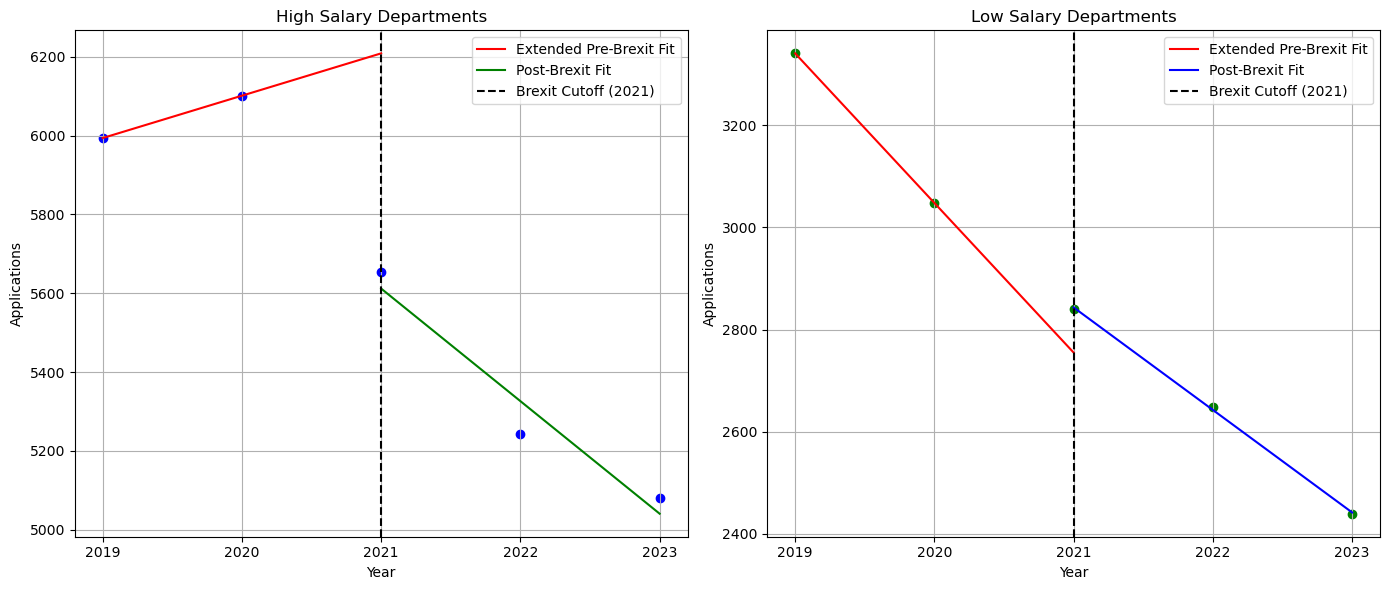

In [42]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load the dataset
cleaned_data = pd.read_csv('Data/PhilipEUCleaned.csv')

# Aggregate application numbers by year and salary group
applications_by_salary_group = cleaned_data.melt(
    id_vars=['Nationality', 'Department', 'Program', 'Salary Group'],
    value_vars=['Applications 2019', 'Applications 2020', 'Applications 2021', 'Applications 2022', 'Applications 2023'],
    var_name='Year',
    value_name='Applications'
)
applications_by_salary_group['Year'] = applications_by_salary_group['Year'].str.extract('(\d+)').astype(int)
applications_by_salary_group = applications_by_salary_group.groupby(['Year', 'Salary Group'])['Applications'].sum().reset_index()


# Create rdf_high and rdf_low from the applications_by_salary_group
rdf_high = applications_by_salary_group[applications_by_salary_group['Salary Group'] == 'High']
rdf_low = applications_by_salary_group[applications_by_salary_group['Salary Group'] == 'Low']

# Preparing data for piecewise linear regression fitting
# Splitting the data based on the Brexit cutoff

# Data before the Brexit cutoff
pre_brexit_data_high = rdf_high[rdf_high['Year'] <= 2020]
pre_brexit_data_low = rdf_low[rdf_low['Year'] <= 2020]

# Data after the Brexit cutoff
post_brexit_data_high = rdf_high[rdf_high['Year'] > 2020]
post_brexit_data_low = rdf_low[rdf_low['Year'] > 2020]

# Fit the models for each segment
model_pre_high = sm.OLS(pre_brexit_data_high['Applications'], sm.add_constant(pre_brexit_data_high['Year'])).fit()
model_post_high = sm.OLS(post_brexit_data_high['Applications'], sm.add_constant(post_brexit_data_high['Year'])).fit()

model_pre_low = sm.OLS(pre_brexit_data_low['Applications'], sm.add_constant(pre_brexit_data_low['Year'])).fit()
model_post_low = sm.OLS(post_brexit_data_low['Applications'], sm.add_constant(post_brexit_data_low['Year'])).fit()

# Predict values for a smoother line
fit_pre_high = model_pre_high.predict(sm.add_constant([2019, 2020]))
fit_post_high = model_post_high.predict(sm.add_constant([2021, 2022, 2023]))

fit_pre_low = model_pre_low.predict(sm.add_constant([2019, 2020]))
fit_post_low = model_post_low.predict(sm.add_constant([2021, 2022, 2023]))

extended_pre_brexit_years_high = np.array([2019, 2020, 2021])
extended_pre_brexit_years_low = np.array([2019, 2020, 2021])
extended_fit_pre_high = model_pre_high.predict(sm.add_constant(extended_pre_brexit_years_high))
extended_fit_pre_low = model_pre_low.predict(sm.add_constant(extended_pre_brexit_years_low))

# Plotting with the adjusted cutoff line, extrapolated pre-Brexit line, and gridlines
plt.figure(figsize=(14, 6))

# High salary departments
plt.subplot(1, 2, 1)
plt.scatter(rdf_high['Year'], rdf_high['Applications'], color='blue')
plt.plot(extended_pre_brexit_years_high, extended_fit_pre_high, color='red', label='Extended Pre-Brexit Fit')
plt.plot([2021, 2022, 2023], fit_post_high, color='green', label='Post-Brexit Fit')
plt.axvline(x=2021, color='black', linestyle='--', label='Brexit Cutoff (2021)')
plt.title('High Salary Departments')
plt.xlabel('Year')
plt.ylabel('Applications')
plt.xticks(range(2019, 2024))
plt.grid(True)
plt.legend()

# Low salary departments
plt.subplot(1, 2, 2)
plt.scatter(rdf_low['Year'], rdf_low['Applications'], color='green')
plt.plot(extended_pre_brexit_years_low, extended_fit_pre_low, color='red', label='Extended Pre-Brexit Fit')
plt.plot([2021, 2022, 2023], fit_post_low, color='blue', label='Post-Brexit Fit')
plt.axvline(x=2021, color='black', linestyle='--', label='Brexit Cutoff (2021)')
plt.title('Low Salary Departments')
plt.xlabel('Year')
plt.xticks(range(2019, 2024))
plt.ylabel('Applications')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [43]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Load the dataset
cleaned_data = pd.read_csv('Data/PhilipEUCleaned.csv')

# Aggregate application numbers by year and salary group
applications_by_salary_group = cleaned_data.melt(
    id_vars=['Nationality', 'Department', 'Program', 'Salary Group'],
    value_vars=['Applications 2019', 'Applications 2020', 'Applications 2021', 'Applications 2022', 'Applications 2023'],
    var_name='Year',
    value_name='Applications'
)
applications_by_salary_group['Year'] = applications_by_salary_group['Year'].str.extract('(\d+)').astype(int)
applications_by_salary_group = applications_by_salary_group.groupby(['Year', 'Salary Group'])['Applications'].sum().reset_index()

# Splitting the data based on the Brexit cutoff for high and low salary groups
pre_brexit_data_high = applications_by_salary_group[(applications_by_salary_group['Salary Group'] == 'High') & (applications_by_salary_group['Year'] <= 2020)]
post_brexit_data_high = applications_by_salary_group[(applications_by_salary_group['Salary Group'] == 'High') & (applications_by_salary_group['Year'] > 2020)]

pre_brexit_data_low = applications_by_salary_group[(applications_by_salary_group['Salary Group'] == 'Low') & (applications_by_salary_group['Year'] <= 2020)]
post_brexit_data_low = applications_by_salary_group[(applications_by_salary_group['Salary Group'] == 'Low') & (applications_by_salary_group['Year'] > 2020)]

# Fit the models for each segment
model_pre_high = sm.OLS(pre_brexit_data_high['Applications'], sm.add_constant(pre_brexit_data_high['Year'])).fit()
model_post_high = sm.OLS(post_brexit_data_high['Applications'], sm.add_constant(post_brexit_data_high['Year'])).fit()

model_pre_low = sm.OLS(pre_brexit_data_low['Applications'], sm.add_constant(pre_brexit_data_low['Year'])).fit()
model_post_low = sm.OLS(post_brexit_data_low['Applications'], sm.add_constant(post_brexit_data_low['Year'])).fit()

# Summary tables for regression models
summary_pre_high = model_pre_high.summary()
summary_post_high = model_post_high.summary()
summary_pre_low = model_pre_low.summary()
summary_post_low = model_post_low.summary()

# Output the summaries
print("High Salary Group - Pre-Brexit Model Summary:\n", summary_pre_high)
print("High Salary Group - Post-Brexit Model Summary:\n", summary_post_high)
print("Low Salary Group - Pre-Brexit Model Summary:\n", summary_pre_low)
print("Low Salary Group - Post-Brexit Model Summary:\n", summary_post_low)


High Salary Group - Pre-Brexit Model Summary:
                             OLS Regression Results                            
Dep. Variable:           Applications   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 25 Apr 2024   Prob (F-statistic):                nan
Time:                        23:39:43   Log-Likelihood:                 37.940
No. Observations:                   2   AIC:                            -71.88
Df Residuals:                       0   BIC:                            -74.49
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const

/Users/maxijaeger/anaconda3/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 2 samples were given.

/Users/maxijaeger/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning:

divide by zero encountered in divide

/Users/maxijaeger/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning:

invalid value encountered in scalar multiply

/Users/maxijaeger/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/maxijaeger/anaconda3/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 3 samples were given.

/Users/maxijaeger/anaconda3/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning:

omni_normtest is not valid with

Summary of Pre-Brexit Model for High Salary Group:
                             OLS Regression Results                            
Dep. Variable:           Applications   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 26 Apr 2024   Prob (F-statistic):                nan
Time:                        02:06:47   Log-Likelihood:                 33.066
No. Observations:                   2   AIC:                            -62.13
Df Residuals:                       0   BIC:                            -64.75
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

/Users/timgrutimner/anaconda3/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 2 samples were given.

/Users/timgrutimner/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning:

divide by zero encountered in divide

/Users/timgrutimner/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning:

invalid value encountered in scalar multiply

/Users/timgrutimner/anaconda3/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarning:

divide by zero encountered in scalar divide

/Users/timgrutimner/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:1529: RuntimeWarning:

invalid value encountered in multiply

/Users/timgrutimner/anaconda3/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 3 sa

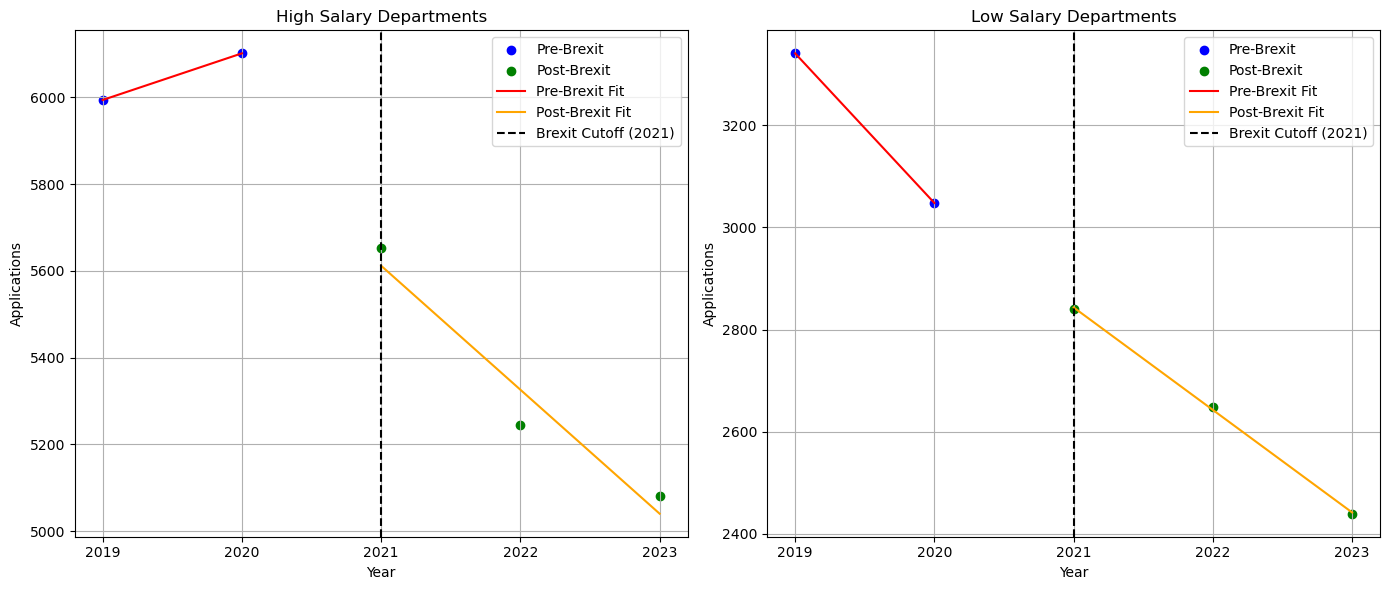

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load the dataset
cleaned_data = pd.read_csv('Data/PhilipEUCleaned.csv')

# Aggregate application numbers by year and salary group
applications_by_salary_group = cleaned_data.melt(
    id_vars=['Nationality', 'Department', 'Program', 'Salary Group'],
    value_vars=['Applications 2019', 'Applications 2020', 'Applications 2021', 'Applications 2022', 'Applications 2023'],
    var_name='Year',
    value_name='Applications'
)
applications_by_salary_group['Year'] = applications_by_salary_group['Year'].str.extract('(\d+)').astype(int)
applications_by_salary_group = applications_by_salary_group.groupby(['Year', 'Salary Group'])['Applications'].sum().reset_index()

# Determine the Brexit cutoff year
cutoff_year = 2021

# Create columns for 'Brexit' and 'Year_Brexit'
applications_by_salary_group['Brexit'] = (applications_by_salary_group['Year'] >= cutoff_year).astype(int)
applications_by_salary_group['Year_Brexit'] = applications_by_salary_group['Year'] * applications_by_salary_group['Brexit']

# Splitting the data based on the Brexit cutoff for high and low salary groups
pre_brexit_data_high = applications_by_salary_group[(applications_by_salary_group['Salary Group'] == 'High') & (applications_by_salary_group['Year'] < cutoff_year)]
post_brexit_data_high = applications_by_salary_group[(applications_by_salary_group['Salary Group'] == 'High') & (applications_by_salary_group['Year'] >= cutoff_year)]

pre_brexit_data_low = applications_by_salary_group[(applications_by_salary_group['Salary Group'] == 'Low') & (applications_by_salary_group['Year'] < cutoff_year)]
post_brexit_data_low = applications_by_salary_group[(applications_by_salary_group['Salary Group'] == 'Low') & (applications_by_salary_group['Year'] >= cutoff_year)]

# Fit the models for each segment
model_pre_high = sm.OLS(pre_brexit_data_high['Applications'], 
                        sm.add_constant(pre_brexit_data_high[['Year', 'Brexit', 'Year_Brexit']])).fit()
model_post_high = sm.OLS(post_brexit_data_high['Applications'], 
                         sm.add_constant(post_brexit_data_high[['Year', 'Brexit', 'Year_Brexit']])).fit()

model_pre_low = sm.OLS(pre_brexit_data_low['Applications'], 
                       sm.add_constant(pre_brexit_data_low[['Year', 'Brexit', 'Year_Brexit']])).fit()
model_post_low = sm.OLS(post_brexit_data_low['Applications'], 
                        sm.add_constant(post_brexit_data_low[['Year', 'Brexit', 'Year_Brexit']])).fit()

# Summary tables for regression models
summary_pre_high = model_pre_high.summary()
summary_post_high = model_post_high.summary()
summary_pre_low = model_pre_low.summary()
summary_post_low = model_post_low.summary()

print("Summary of Pre-Brexit Model for High Salary Group:\n", summary_pre_high)
print("\nSummary of Post-Brexit Model for High Salary Group:\n", summary_post_high)
print("\nSummary of Pre-Brexit Model for Low Salary Group:\n", summary_pre_low)
print("\nSummary of Post-Brexit Model for Low Salary Group:\n", summary_post_low)

# Predict values for a smoother line
fit_pre_high = model_pre_high.predict(sm.add_constant(pre_brexit_data_high[['Year', 'Brexit', 'Year_Brexit']]))
fit_post_high = model_post_high.predict(sm.add_constant(post_brexit_data_high[['Year', 'Brexit', 'Year_Brexit']]))
fit_pre_low = model_pre_low.predict(sm.add_constant(pre_brexit_data_low[['Year', 'Brexit', 'Year_Brexit']]))
fit_post_low = model_post_low.predict(sm.add_constant(post_brexit_data_low[['Year', 'Brexit', 'Year_Brexit']]))

# Plotting with the adjusted cutoff line, extrapolated pre-Brexit line, and gridlines
plt.figure(figsize=(14, 6))

# High salary departments
plt.subplot(1, 2, 1)
plt.scatter(pre_brexit_data_high['Year'], pre_brexit_data_high['Applications'], color='blue', label='Pre-Brexit')
plt.scatter(post_brexit_data_high['Year'], post_brexit_data_high['Applications'], color='green', label='Post-Brexit')
plt.plot(pre_brexit_data_high['Year'], fit_pre_high, color='red', label='Pre-Brexit Fit')
plt.plot(post_brexit_data_high['Year'], fit_post_high, color='orange', label='Post-Brexit Fit')
plt.axvline(x=cutoff_year, color='black', linestyle='--', label='Brexit Cutoff (2021)')
plt.title('High Salary Departments')
plt.xlabel('Year')
plt.ylabel('Applications')
plt.xticks(range(2019, 2024))
plt.grid(True)
plt.legend()

# Low salary departments
plt.subplot(1, 2, 2)
plt.scatter(pre_brexit_data_low['Year'], pre_brexit_data_low['Applications'], color='blue', label='Pre-Brexit')
plt.scatter(post_brexit_data_low['Year'], post_brexit_data_low['Applications'], color='green', label='Post-Brexit')
plt.plot(pre_brexit_data_low['Year'], fit_pre_low, color='red', label='Pre-Brexit Fit')
plt.plot(post_brexit_data_low['Year'], fit_post_low, color='orange', label='Post-Brexit Fit')
plt.axvline(x=cutoff_year, color='black', linestyle='--', label='Brexit Cutoff (2021)')
plt.title('Low Salary Departments')
plt.xlabel('Year')
plt.xticks(range(2019, 2024))
plt.ylabel('Applications')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
